In [43]:
def plot_obstacles(obstacles):
    for idx, obstacle in enumerate(obstacles):
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='red', fill=False, label= f'Obstacle {idx}')
        plt.gca().add_patch(circle)
    
    plt.title('Trajectory with Obstacle')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Set axis limits for x and y
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.axis('equal')
    plt.grid()
    plt.show()

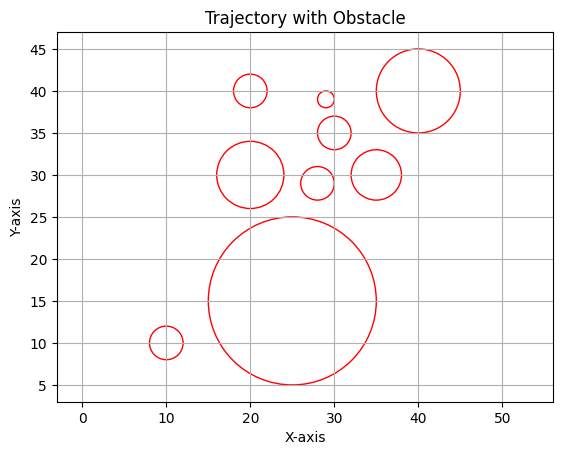

In [44]:
import numpy as np
import casadi as ca
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
from MPC_Animation_Demo_Functions import *

# Define Problem
dt = 0.5
x_init = np.array([0, 0, 0, 0])
x_target = np.array([50, 50, 0, 0])

# Constraints 
pos_constraints = [0, 50, 0, 50]         # [x_min, x_mplt, y_min, y_mplt]
vel_constraints = [-1, 1, -1, 1]         # [x_min, x_mplt, y_min, y_mplt]
acc_constraints = [-1, 1, -1, 1]         # [x_min, x_mplt, y_min, y_mplt]

# # Time Horizon
N = 20
T = 50

# List of obstacles : obstacle = [center_x, center_y, radius]
obstacles = [[20, 40, 2], [35, 30, 3], [10, 10, 2], [25, 15, 10], [20, 30, 4], [40, 40, 5], [29, 39, 1], [30, 35, 2], [28, 29, 2]]

# Simulate the result
vehicle = vehicle_SS(dt)

# Setup controller function
controller = lambda x_init : mpc_control(vehicle, N, x_init, x_target, pos_constraints, vel_constraints, acc_constraints, obstacles)

plot_obstacles(obstacles)


In [45]:
def simulate(dt, T, x_init, plan_length, control_func, num_states = 4, num_inputs = 2):
    ## Timesteps
    timesteps = np.arange(0, T, dt)
    print(f"Timesteps: {len(timesteps)}")

    # Initialise the output arrays
    x_real = np.zeros((num_states, len(timesteps)+1))
    x_all = np.zeros((num_states, plan_length+1, len(timesteps)+1))
    u_real = np.zeros((num_inputs, len(timesteps)))
    
    x_real[:, 0] = x_init
    for t in range(len(timesteps)):

        # Compute the control input (and apply it)
        u_out, x_out, x_all_out = control_func(x_real[:, t]) 

        # Next x is the x in the second state
        x_real[:, t+1] = x_out
        x_all[:, :, t] = x_all_out # Save the plan (for visualization)

        # Used input is the first input
        u_real[:, t] = u_out

    return x_real, u_real, x_all, timesteps

In [46]:
# Simulate drone
states, inputs, plans, timesteps = simulate(dt, T, x_init, N, controller, num_states=4, num_inputs=2)

Timesteps: 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   2.94ms ( 73.45us)        40
       nlp_g  |  15.00ms (375.00us)   7.92ms (198.12us)        40
  nlp_grad_f  |   4.00ms ( 97.56us)   2.41ms ( 58.85us)        41
  nlp_hess_l  |  28.00ms (717.95us)  16.12ms (413.21us)        39
   nlp_jac_g  |  13.00ms (317.07us)  15.47ms (377.34us)        41
       total  | 254.00ms (254.00ms) 259.07ms (259.07ms)         1
Optimal cost: 88151.63204561906
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 875.00us ( 25.00us)        35
       nlp_g  |   2.00ms ( 57.14us)   2.60ms ( 74.26us)        35
  nlp_grad_f  |        0 (       0)   1.24ms ( 34.50us)        36
  nlp_hess_l  |   3.00ms ( 88.24us)   9.84ms (289.47us)        34
   nlp_jac_g  |   7.00ms (194.44us)  11.39ms (316.31us)        36
       total  | 184.00ms (184.00ms) 179.88ms (179.88ms)         1
Optimal cost: 86599.792243607

In [47]:
def update(frame):
    # Clear previous frame
    plt.cla()
    
    # Plot Path for current state
    plt.scatter(plans[0][:, frame], plans[1][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    drone = plt.Circle((states[0][frame], states[1][frame]), 0.7, color='r', fill=True, label = "Drone")
    plt.gca().add_patch(drone)
    
    for obstacle in obstacles:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='k', fill=False)
        plt.gca().add_patch(circle) 

    plt.legend()
    plt.title(f'Time Step {frame + 1}/{len(states[1])}')  # Set title for each frame
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.grid()


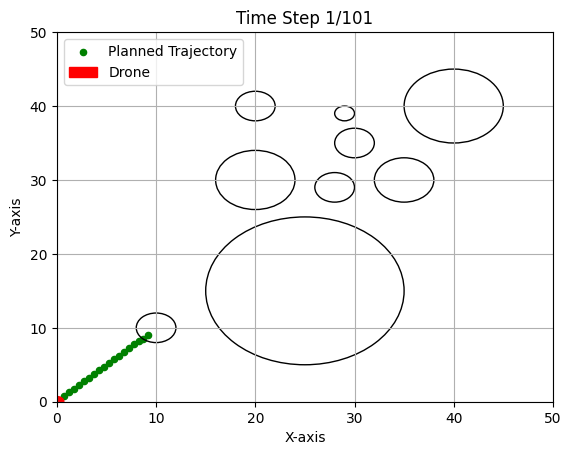

In [48]:
# Create the animation
fig = plt.figure()
ani = FuncAnimation(fig, update, frames=len(timesteps), interval=100)

# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())